 ## Video Pipeline Reading From Multiple Files in rocAL

This example presents a simple rocAL video pipeline that loads and decodes  video data. Illustrated below how to create a pipeline, set_outputs, build, run the pipeline and enumerate over the results.

 ## Common Code

In [7]:
import torch
from amd.rocal.pipeline import Pipeline
import amd.rocal.fn as fn
import amd.rocal.types as types
import numpy as np
import os
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

## Configuring rocAL pipeline
Configure the pipeline parameters as required by the user.

In [8]:
video_path = os.path.join(os.environ['ROCAL_DATA_PATH'], "video_and_sequence_samples", "labelled_videos")
rocal_cpu = True
batch_size = 2
display = False
num_threads = 4
random_seed = 1
tensor_format = types.NCHW
tensor_dtype = types.FLOAT
local_rank = 1
sequence_length = 3
n_iter = 6

In [9]:
def display_sequence(sequence):
    columns = 3
    rows = (sequence_length + 1) // (columns)
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows * columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(sequence)

## Defining and Running the Pipeline
Creating the pipeline using video readers for reading the video data.In this pipeline we add cascaded augmentation on the decoded sequence. We enable the output for differnet augmentaion using set_output



In [10]:
class ROCALVideoIterator(object):
    """
    ROCALVideoIterator for pyTorch.

    Parameters
    ----------
    pipelines : list of amd.rocal.pipeline.Pipeline
                List of pipelines to use
    size : int
           Epoch size.
    """

    def __init__(self, pipelines, tensor_layout=types.NCHW, reverse_channels=False, multiplier=None, offset=None, tensor_dtype=types.FLOAT, display=False, sequence_length=3):

        try:
            assert pipelines is not None, "Number of provided pipelines has to be at least 1"
        except Exception as ex:
            print(ex)

        self.loader = pipelines
        self.tensor_format = tensor_layout
        self.multiplier = multiplier if multiplier else [1.0, 1.0, 1.0]
        self.offset = offset if offset else [0.0, 0.0, 0.0]
        self.reverse_channels = reverse_channels
        self.tensor_dtype = tensor_dtype
        self.batch_size = self.loader._batch_size
        self.rim = self.loader.get_remaining_images()
        self.display = display
        self.iter_num = 0
        self.sequence_length = sequence_length
        self.output = self.dimensions = self.dtype = None

    def next(self):
        return self.__next__()

    def __next__(self):
        if self.loader.is_empty():
            raise StopIteration

        if self.loader.rocal_run() != 0:
            raise StopIteration
        else:
            self.output_tensor_list = self.loader.get_output_tensors()
        self.iter_num += 1
        # Copy output from buffer to numpy array
        if self.output is None:
            self.dimensions = self.output_tensor_list[0].dimensions()
            self.dtype = self.output_tensor_list[0].dtype()
            self.layout = self.output_tensor_list[0].layout()
            self.output = np.empty((self.dimensions[0] * self.dimensions[1], self.dimensions[2], self.dimensions[3], self.dimensions[4]), dtype=self.dtype)
        self.output_tensor_list[0].copy_data(self.output)
        img = torch.from_numpy(self.output)
        return img

    def reset(self):
        self.loader.rocal_reset_loaders()

    def __iter__(self):
        return self

    def __del__(self):
        self.loader.rocal_release()


In [11]:
pipe = Pipeline(batch_size=batch_size, num_threads=num_threads, device_id=local_rank, seed=random_seed, rocal_cpu=rocal_cpu,
                tensor_layout=tensor_format, tensor_dtype=tensor_dtype)

Pipeline has been created succesfully
OK: loaded 114 kernels from libvx_rpp.so


## Video Pipeline
Here we use the video reader to read the video data. Then the decoded sequences is passed to CMN.We enable the output for CMN using set_output.

In [12]:
with pipe:
    images = fn.readers.video(file_root=video_path, sequence_length=sequence_length,
                              random_shuffle=False, image_type=types.RGB)
    crop_size = [512, 960]
    output_images = fn.crop_mirror_normalize(images,
                                             crop=crop_size,
                                             mean=[0, 0, 0],
                                             std=[1, 1, 1],
                                             mirror=0,
                                             output_dtype=types.UINT8,
                                             output_layout=types.NFHWC)
    pipe.set_outputs(output_images)

## Building the Pipeline
Here we are creating the pipeline. In order to use our Pipeline, we need to build it. This is achieved by calling the build function. Then iterator object is created with ROCALVideoIterator(video_pipeline)

In [13]:
# Build the pipeline
pipe.build()

In [14]:
# Dataloader
data_loader = ROCALVideoIterator(pipe, multiplier=pipe._multiplier, offset=pipe._offset, display=display, sequence_length=sequence_length)

## Visualizing outputs
We have plotted the output of the video sequence using matplotlib

/tmp/ipykernel_635655/2287653203.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(gs[j])


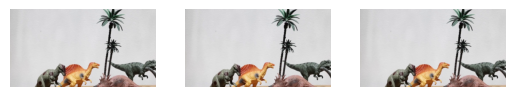

In [15]:
for i, it in enumerate(data_loader):
    if i == n_iter:
        break
    for sequence in it:
        display_sequence(sequence)
data_loader.reset()